In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import modelisation_functions as mf
from random import sample 
import warnings
warnings.filterwarnings('ignore')

- On fait fonction pour filtre les crises avec au moins 15 sec. 
- On fait une fonction LOO, input : data, non crise ou non patient
- On fait une fonction de score fichier à 5 secondes : 
    - sens
    - FPR
    - AUC   
.
- Random fields 


# Fonctions & csts

In [2]:
dir_save_score = 'saved_scores/'
datas_file = '../features_engineering/saved_features/saved_features_E20.csv'
datas = pd.read_csv(datas_file,index_col = 0)

evt_bdg = pd.read_csv('../../data/preprocessing/simplified_evt.csv', index_col=0)

datas['label'] = [int(i > 0) for i in datas['label'].tolist()]
patient = [sz[15:18] for sz in datas.evt_name.tolist()]
datas['patient'] = patient

'''
features post treatment
'''
list_features_model = datas.columns.tolist()[3:-1]
var_to_remove = ['spectre_MSG','spectre_MSD']
for var in var_to_remove:
    list_features_model.remove(var)

list_uniq_seizure = list(set(datas.evt_name))

'''
On fait une liste des crises par patient on pourrait en avoir besoin 
'''
list_uniq_patient = list(set(datas.patient.tolist()))

dict_patient_seizures = dict()
for patient in list_uniq_patient:
    list_sz_patient = list(datas[datas.patient == patient].evt_name.unique())
    dict_patient_seizures[patient] = list_sz_patient

In [11]:
def train_test_from_sz(df,evt_name,col_model):
    '''
    return x_train, x_test, y_... 
    '''
    df_train = df[df.evt_name != evt_name]
    df_test = df[df.evt_name == evt_name]

    return df_train[col_model], df_test[col_model],df_train['label'], df_test['label']

def train_test_from_patient(df,patient,col_model):

    '''
    return x,y :
    - train on very patient but the selected
    - test on the selected patient
    '''

    df_train = df[df.patient != patient]
    df_test = df[df.patient == patient]

    return df_train[col_model], df_test[col_model],df_train['label'], df_test['label']
    
def loc_f1_score(tn, fp, fn, tp ):
    '''
    return f1 score from tn, fp, fn, tp
    '''
    loc_f1_score = 2 * ((tp/(tp+fp)) * (tp/(tp+fn))) / (tp / (tp + fp) + tp / (tp + fn))
    return(loc_f1_score)

def get_x_test_y_test(df,features):
    '''
    return x et y from dataframe
    '''
    x_test = df[features]
    y_test = df['label']
    
    return(x_test,y_test)

# Modelisation 

0. On fait un modèle de prédiction sur des fenêtres de 5 secondes. 
    0.0 TC

    0.1 > 15 sec. 
    
    0.2 Random fields 

In [12]:
def df_from_seizure_type(list_seizure,data,bdd):
    '''
    return a dataframe with only seizure of selected type
    input
    - list of seizure type
    output 
    - the dataframe
    - the list of sz
    '''
    list_sz = bdd[bdd.STY.isin(list_seizure)].filename.unique()
    list_sz = [i[:-4] for i in list_sz]
    data = data[data.evt_name.isin(list_sz)]
    list_sz = data.evt_name.unique()

    return(data,list_sz)

def filter_duration(datas, filter_sec):
    '''
    return a dataframe with only seizure longer than filter_sec
    '''
    list_sz = datas.evt_name.unique().tolist()
    list_ok_sz = []
    for sz in list_sz:
        toto = datas[datas.evt_name == sz]
        duration = np.sum(toto.label)
        if duration > filter_sec:
            list_ok_sz.append(sz)
    datas = datas[datas.evt_name.isin(list_ok_sz)]
    
    return(datas)

In [13]:
data_tc, list_tc = df_from_seizure_type(['TC'],datas,evt_bdg)

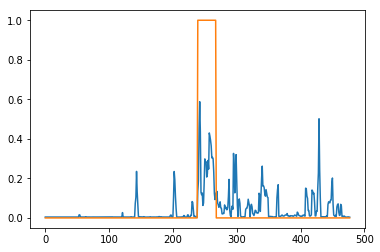

In [46]:
abs = range(len(y_pred))
plt.plot(abs,y_pred_proba)
plt.plot(abs,y_test)


In [16]:
list_tc

array(['20060131T090000REVCAM', '20060316T195559HUNHEL',
       '20091027T145300SOA', '20061013T134300GILMEL',
       '20070523T150800ANDSTE', '20091015T154300CHM',
       '20100125T120330BOA', '20070613T144200RAVFRA',
       '20061108T092900MALSTE', '20061108T104000MALSTE',
       '20091117T144700KSY', '20060510T151930MORGUI',
       '20070221T151000MARMIR', '20091207T130700TSL'], dtype=object)

In [7]:
'''
on insctancie un nouveau modèle de forêt aléatoire
'''
rfc = RandomForestClassifier(max_depth = 6,n_estimators = 50,max_features = 2)


list_for_model = list_tc
columns_score = ['evt_name','sens','spec','fn','tp']
df_score = pd.DataFrame(columns = columns_score)
i = 0
for sz in list_for_model[0:1]:
    x_train, x_test, y_train, y_test = train_test_from_sz(datas,sz,list_features_model)
    '''
    J4entraïne mon modèle sur x_train, y_train
    '''
    rfc.fit(x_train,y_train)
    y_pred = rfc.predict(x_test)
    y_pred_proba = rfc.predict_proba(x_test)
    y_pred_proba = y_pred_proba[:,1]

    try:
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        sens = tp / (tp + fn)
        spec = tn / (tn + fp)
    except:
        f1_score,sens,spec,fn,tp = np.NAN,np.NAN,np.NAN,np.NAN,np.NAN
        print('exception')

    df_score.loc[sz] = [sz, sens,spec,fn, tp] 

fn_glon = df_score.fn.sum()
tp_glob = df_score.tp.sum() 
sens_glob = stp / (stp + sfn)
print('sensibilité = ', sens)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


## Conditional random fieds

## Graph

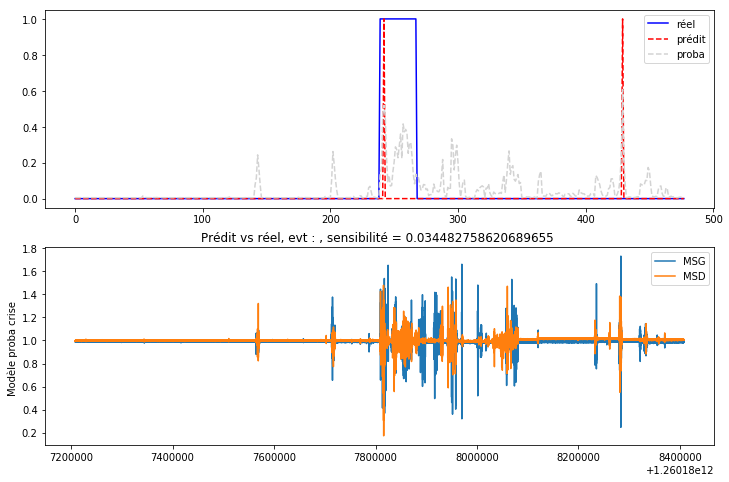

In [13]:
dir_graph_files = '../../data/filtered_and_labeled_evt'
df_graph = pd.read_csv(dir_graph_files + '/' + sz + ('.csv'),index_col = 0)
# df_graph = reset_timeline(df_graph)

fig , ax = plt.subplots(2,1,figsize = (12,8))
ax[0].plot(y_test,label = 'reel',color = 'blue')
ax[0].plot(y_pred,'--', label = 'prédit',color = 'red')
ax[0].plot(y_pred_proba,'--', label = 'prédit proba',color = 'lightgrey')
ax[0].legend(['réel','prédit','proba'])
ax[1].plot(df_graph.timeline,df_graph.MSG)
ax[1].plot(df_graph.timeline,df_graph.MSD)
plt.legend()
plt.title('Prédit vs réel, evt : , sensibilité = {} '.format(sens))
plt.ylabel('Modèle proba crise ') 
plt.show()

In [ ]:


save_file = False

columns_score = ['patient','evt_name','is_seizure','sensibilité','fn','tp']
df_score = pd.DataFrame(columns = columns_score)

for patient in list_for_model:
    x_train, x_test, y_train, y_test = train_test_from_patient(datas,patient,list_features_model)
    rfc.fit(x_train,y_train)
    list_seizure_patient = dict_patient_seizures[patient]

    for seizure in list_seizure_patient:
        df_seizure = datas[datas.evt_name == seizure]
        x_test,y_test = get_x_test_y_test(df_seizure,list_features_model)
        y_pred = rfc.predict(x_test)
        y_pred_proba = rfc.predict_proba(x_test)
        y_pred_proba = y_pred_proba[:,1]
        is_seizure = np.max(y_pred_proba)

        try:
            tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
            sensibilité = tp / (tp + fn)
        except:
            f1_score,sensibilité,tn,fp = np.NAN,np.NAN,np.NAN,np.NAN

        df_score.loc[seizure] = [patient,seizure,is_seizure,f1_score, sensibilité,fn, tp] 
        
if save_file == True:
        df_score.to_csv(dir_save_score + 'score_E10_F8.csv')

df_score_patient = df_score.groupby('patient').max()